In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


### Import libraries

In [2]:
# Import libraries
import seaborn as sns
import statsmodels.api as sm
import pystan
import sklearn.metrics as sk
from statsmodels.stats import outliers_influence
import scipy.stats as stats

### Load data

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory data analysis

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
print(train.groupby(['Sex']).agg({'PassengerId':'count','Survived':'mean'}))
# print(train.groupby(['Pclass']).agg({'PassengerId':'count','Survived':'mean'}))
print(train.groupby(['Sex','Pclass']).agg({'PassengerId':'count','Survived':'mean'}))
print(train.groupby(['Sex','SibSp']).agg({'PassengerId':'count','Survived':'mean'}))
print(train.groupby(['Sex','Parch']).agg({'PassengerId':'count','Survived':'mean'}))
print(train.groupby(['Sex','Pclass','Embarked']).agg({'PassengerId':'count','Survived':'mean'}))

        PassengerId  Survived
Sex                          
female          314  0.742038
male            577  0.188908
               PassengerId  Survived
Sex    Pclass                       
female 1                94  0.968085
       2                76  0.921053
       3               144  0.500000
male   1               122  0.368852
       2               108  0.157407
       3               347  0.135447
              PassengerId  Survived
Sex    SibSp                       
female 0              174  0.787356
       1              106  0.754717
       2               13  0.769231
       3               11  0.363636
       4                6  0.333333
       5                1  0.000000
       8                3  0.000000
male   0              434  0.168203
       1              103  0.310680
       2               15  0.200000
       3                5  0.000000
       4               12  0.083333
       5                4  0.000000
       8                4  0.000000
        

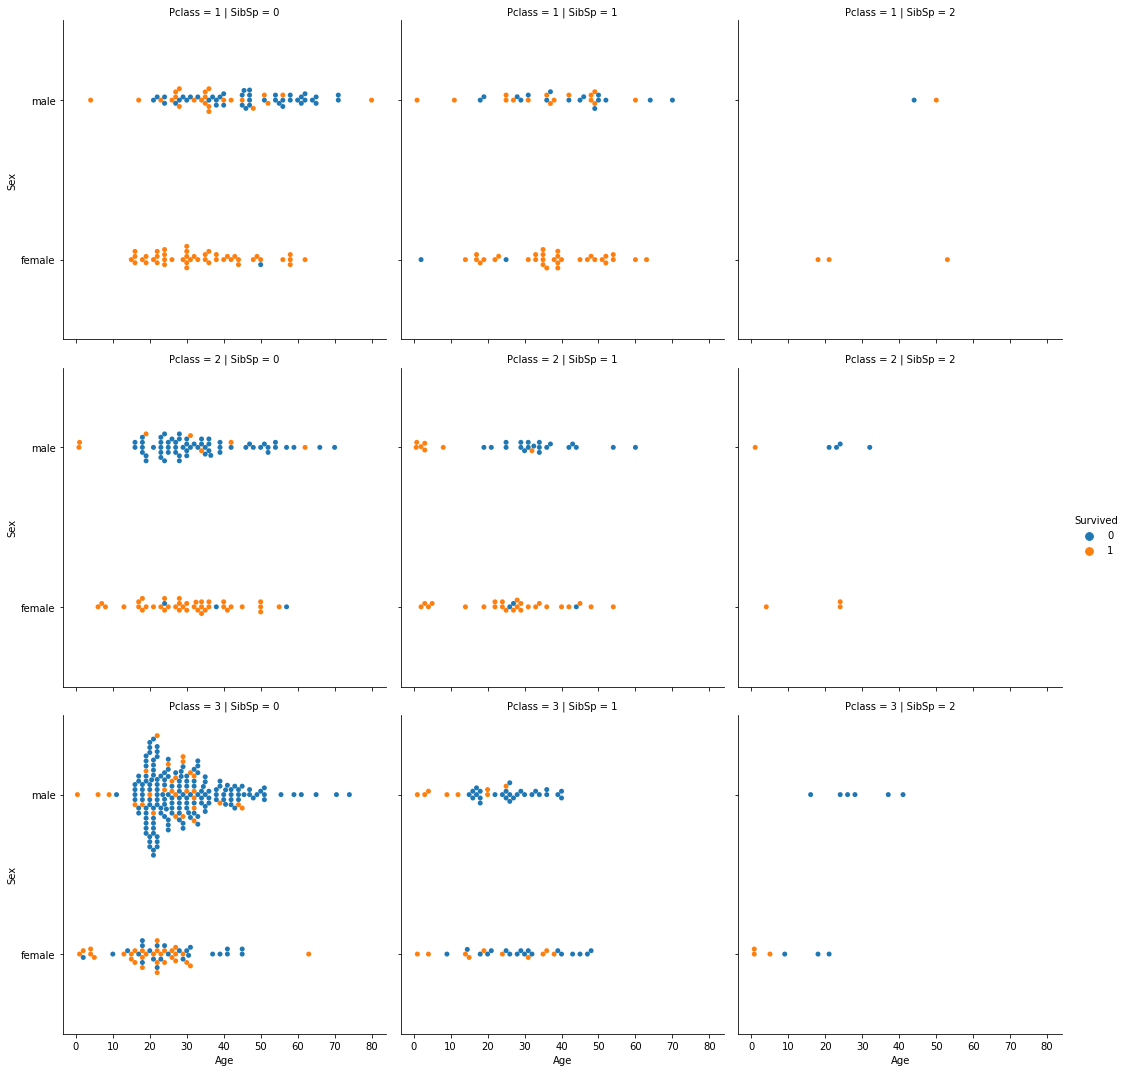

In [8]:
# Plot Age and Fare with Survival
temp = train.copy()
# temp['Fare50'] = 0
# temp.loc[temp['Fare']>=50,'Fare50']=1
sns.catplot(x = 'Age', y = 'Sex', row='Pclass', col='SibSp', hue='Survived',kind='swarm', data=temp[(temp['Age']>0) & (temp['SibSp']<=2)])
# Heavy tail, bump at lower age survival

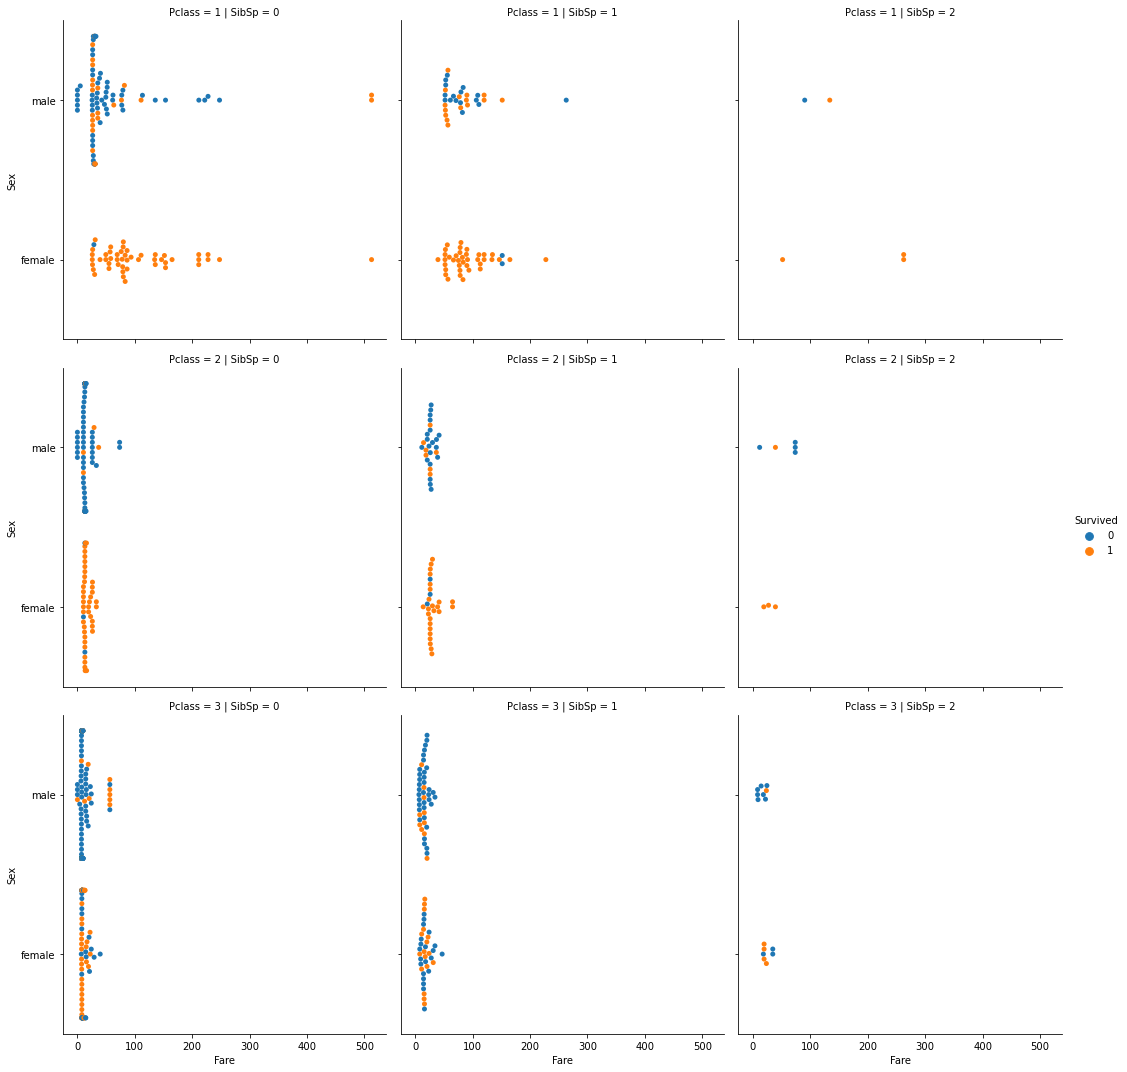

In [9]:
sns.catplot(x = 'Fare', y = 'Sex', row='Pclass', col='SibSp', hue='Survived',kind='swarm', data=temp[pd.notnull(temp['Fare']) & (temp['SibSp']<=2)])

### Transform variables

In [10]:
# Add children indicator
train['Children'] = 0 
train.loc[pd.notnull(train['Age'])&(train['Age']<16),'Children']=1
test['Children'] = 0 
test.loc[pd.notnull(test['Age'])&(test['Age']<16),'Children']=1

# Add female indicator
train['Female'] = 0
train.loc[pd.notnull(train['Sex'])&(train['Sex']=='female'),'Female']=1
test['Female'] = 0
test.loc[pd.notnull(test['Sex'])&(test['Sex']=='female'),'Female']=1

In [11]:
# Encode dummies
def one_hot_encoding(df, col):
    df = pd.get_dummies(df, columns=col)
    return df

train = one_hot_encoding(train, col=['Pclass','SibSp','Parch'])
train = train.drop(columns=['Pclass_3', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8','Parch_3', 'Parch_4', 'Parch_5', 'Parch_6'])
test = one_hot_encoding(test, col=['Pclass','SibSp','Parch'])
test = test.drop(columns=['Pclass_3', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8','Parch_3', 'Parch_4', 'Parch_5', 'Parch_6'])

In [12]:
test.head()

,PassengerId,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Children,Female,Pclass_1,Pclass_2,SibSp_0,SibSp_1,SibSp_2,Parch_0,Parch_1,Parch_2,Parch_9
0,892,"Kelly, Mr. James",male,34.5,330911,7.8292,NaN,Q,0,0,0,0,1,0,0,1,0,0,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,363272,7.0000,NaN,S,0,1,0,0,0,1,0,1,0,0,0
2,894,"Myles, Mr. Thomas Francis",male,62.0,240276,9.6875,NaN,Q,0,0,0,1,1,0,0,1,0,0,0
3,895,"Wirz, Mr. Albert",male,27.0,315154,8.6625,NaN,S,0,0,0,0,1,0,0,1,0,0,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,3101298,12.2875,NaN,S,0,1,0,0,0,1,0,0,1,0,0


In [13]:
train.describe()

,PassengerId,Survived,Age,Fare,Children,Female,Pclass_1,Pclass_2,SibSp_0,SibSp_1,SibSp_2,Parch_0,Parch_1,Parch_2
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,32.204208,0.093154,0.352413,0.242424,0.206510,0.682379,0.234568,0.031425,0.760943,0.132435,0.089787
std,257.353842,0.486592,14.526497,49.693429,0.290811,0.477990,0.428790,0.405028,0.465813,0.423966,0.174562,0.426747,0.339154,0.286037
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,446.000000,0.000000,28.000000,14.454200,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,668.500000,1.000000,38.000000,31.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
train.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Children', 'Female', 'Pclass_1', 'Pclass_2',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'Parch_0', 'Parch_1', 'Parch_2'],
      dtype='object')

### Create interaction variables
2-level interaction of indicator variables

In [15]:
# Create interaction variables
# Categories:
# Children
# Female
# Pclass 1,2,3
# SibSp 0,1,2
# Parch 0,1,2
def create_interactions(var, df1, df2, interaction_list):
    for i in interaction_list:
        new_var = var+'_'+i
        df1[new_var] = df1[var]*df1[i]
        df2[new_var] = df2[var]*df2[i]
    return df1, df2

In [16]:
features = ['Children', 'Female', 'Pclass_1', 'Pclass_2', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'Parch_0', 'Parch_1', 'Parch_2']
train_X = train[features].copy()
test_X = test[features].copy()
features.remove('Children')
train_X, test_X = create_interactions('Children', train_X, test_X, features)
features.remove('Female')
train_X, test_X = create_interactions('Female', train_X, test_X, features)
train_X, test_X = create_interactions('Pclass_1', train_X, test_X, ['SibSp_0', 'SibSp_1', 'SibSp_2', 'Parch_0', 'Parch_1', 'Parch_2'])
train_X, test_X = create_interactions('Pclass_2', train_X, test_X, ['SibSp_0', 'SibSp_1', 'SibSp_2', 'Parch_0', 'Parch_1', 'Parch_2'])
train_X, test_X = create_interactions('SibSp_0', train_X, test_X, ['Parch_0', 'Parch_1', 'Parch_2'])
train_X, test_X = create_interactions('SibSp_1', train_X, test_X, ['Parch_0', 'Parch_1', 'Parch_2'])
train_X, test_X = create_interactions('SibSp_2', train_X, test_X, ['Parch_0', 'Parch_1', 'Parch_2'])
train_X.columns

Index(['Children', 'Female', 'Pclass_1', 'Pclass_2', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'Parch_0', 'Parch_1', 'Parch_2', 'Children_Female',
       'Children_Pclass_1', 'Children_Pclass_2', 'Children_SibSp_0',
       'Children_SibSp_1', 'Children_SibSp_2', 'Children_Parch_0',
       'Children_Parch_1', 'Children_Parch_2', 'Female_Pclass_1',
       'Female_Pclass_2', 'Female_SibSp_0', 'Female_SibSp_1', 'Female_SibSp_2',
       'Female_Parch_0', 'Female_Parch_1', 'Female_Parch_2',
       'Pclass_1_SibSp_0', 'Pclass_1_SibSp_1', 'Pclass_1_SibSp_2',
       'Pclass_1_Parch_0', 'Pclass_1_Parch_1', 'Pclass_1_Parch_2',
       'Pclass_2_SibSp_0', 'Pclass_2_SibSp_1', 'Pclass_2_SibSp_2',
       'Pclass_2_Parch_0', 'Pclass_2_Parch_1', 'Pclass_2_Parch_2',
       'SibSp_0_Parch_0', 'SibSp_0_Parch_1', 'SibSp_0_Parch_2',
       'SibSp_1_Parch_0', 'SibSp_1_Parch_1', 'SibSp_1_Parch_2',
       'SibSp_2_Parch_0', 'SibSp_2_Parch_1', 'SibSp_2_Parch_2'],
      dtype='object')

In [17]:
print(train_X.shape)
train_X.describe().iloc[:,0:20]
# Age has nulls, needs imputation before it can be used
# Fare needs some form of imputation or transformation before it can be used

(891, 48)


,Children,Female,Pclass_1,Pclass_2,SibSp_0,SibSp_1,SibSp_2,Parch_0,Parch_1,Parch_2,Children_Female,Children_Pclass_1,Children_Pclass_2,Children_SibSp_0,Children_SibSp_1,Children_SibSp_2,Children_Parch_0,Children_Parch_1,Children_Parch_2,Female_Pclass_1
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.093154,0.352413,0.242424,0.206510,0.682379,0.234568,0.031425,0.760943,0.132435,0.089787,0.048260,0.006734,0.021324,0.025814,0.030303,0.006734,0.012346,0.043771,0.037037,0.105499
std,0.290811,0.477990,0.428790,0.405028,0.465813,0.423966,0.174562,0.426747,0.339154,0.286037,0.214436,0.081830,0.144544,0.158668,0.171516,0.081830,0.110485,0.204700,0.188959,0.307368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Logistic Regression
Test interaction variables and continous variables

In [18]:
train_X = sm.add_constant(train_X)
test_X = sm.add_constant(test_X)
# train_X.columns

In [19]:
input_vars = ['const',
              'Children',
              'Female',
              'Pclass_1',
              'Pclass_2',
#               'SibSp_0',
              'SibSp_1',
              'SibSp_2',
#               'Parch_0', # High VIF
              'Parch_1',
              'Parch_2',
              'Children_Female', 'Children_Pclass_1', 'Children_Pclass_2',
#               'Children_SibSp_0',
              'Children_SibSp_1', 'Children_SibSp_2',
#               'Children_Parch_0',
              'Children_Parch_1',
              'Children_Parch_2', # VIF infinite
              'Female_Pclass_1', 'Female_Pclass_2',
#               'Female_SibSp_0', # High VIF
              'Female_SibSp_1', 'Female_SibSp_2',
#               'Female_Parch_0', # High VIF
              'Female_Parch_1',
              'Female_Parch_2',
#               'Pclass_1_SibSp_0', # High VIF
              'Pclass_1_SibSp_1', 'Pclass_1_SibSp_2',
#               'Pclass_1_Parch_0', # High VIF
              'Pclass_1_Parch_1',
              'Pclass_1_Parch_2',
#               'Pclass_2_SibSp_0', # High VIF
              'Pclass_2_SibSp_1', 'Pclass_2_SibSp_2',
#               'Pclass_2_Parch_0', # High VIF
              'Pclass_2_Parch_1', 'Pclass_2_Parch_2',
              'SibSp_0_Parch_0', # High VIF
#               'SibSp_0_Parch_1',
#               'SibSp_0_Parch_2',
#               'SibSp_1_Parch_0', # High VIF
              'SibSp_1_Parch_1', # High VIF
              'SibSp_1_Parch_2',
#               'SibSp_2_Parch_0', # High VIF
              'SibSp_2_Parch_1',
              'SibSp_2_Parch_2'
             ]

In [20]:
# Fit logistic regression
logistic_reg = sm.GLM(train['Survived'], train_X[input_vars], family=sm.families.Binomial()).fit()
print(logistic_reg.summary())
print(sk.roc_auc_score(train['Survived'], logistic_reg.predict()))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      856
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -359.50
Date:                Tue, 13 Oct 2020   Deviance:                       719.00
Time:                        13:56:56   Pearson chi2:                     860.
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.7825      0.92

In [21]:
# Compute VIF
train_data = train_X[input_vars].copy()
train_data = train_data.drop(['const'], axis=1)
VIF = pd.Series([outliers_influence.variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])],
               index= train_data.columns)
print(VIF)

Children             14.471565
Female                4.513066
Pclass_1              3.097857
Pclass_2              2.804390
SibSp_1               4.910388
SibSp_2               2.884487
Parch_1               8.079874
Parch_2               6.606100
Children_Female       3.721168
Children_Pclass_1     1.857632
Children_Pclass_2     2.574965
Children_SibSp_1      2.801108
Children_SibSp_2      3.565887
Children_Parch_1      6.692124
Children_Parch_2      6.067105
Female_Pclass_1       3.043871
Female_Pclass_2       2.689622
Female_SibSp_1        3.099400
Female_SibSp_2        3.206646
Female_Parch_1        3.222502
Female_Parch_2        3.987763
Pclass_1_SibSp_1      2.868303
Pclass_1_SibSp_2      1.664688
Pclass_1_Parch_1      2.396609
Pclass_1_Parch_2      2.416975
Pclass_2_SibSp_1      2.722234
Pclass_2_SibSp_2      2.099903
Pclass_2_Parch_1      3.032385
Pclass_2_Parch_2      2.273000
SibSp_0_Parch_0       1.896604
SibSp_1_Parch_1       3.360737
SibSp_1_Parch_2       2.258058
SibSp_2_

In [22]:
# Predict test
pred_test = logistic_reg.predict(test_X[input_vars])
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred_test>0.5})
output['Survived']=output['Survived'].astype(int)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [23]:
# Save output
# output.to_csv('logistic_regression.csv', index=False)

### Stan model in C++
Code the model structure for hierarchical logistic regression

In [24]:
# Select the input data for the model
stan_input_vars = ['const',
              'Children',
              'Female',
              'Pclass_1', 'Pclass_2',
#               'SibSp_0',
              'SibSp_1', 'SibSp_2',
#               'Parch_0',
              'Parch_1', 'Parch_2',
              'Children_Female',
              'Children_Pclass_1', 'Children_Pclass_2',
#               'Children_SibSp_0',
              'Children_SibSp_1', 'Children_SibSp_2',
#               'Children_Parch_0',
              'Children_Parch_1', 'Children_Parch_2',
              'Female_Pclass_1', 'Female_Pclass_2',
#               'Female_SibSp_0',
              'Female_SibSp_1', 'Female_SibSp_2',
#               'Female_Parch_0',
              'Female_Parch_1', 'Female_Parch_2',
#               'Pclass_1_SibSp_0',
              'Pclass_1_SibSp_1', 'Pclass_1_SibSp_2',
#               'Pclass_1_Parch_0',
              'Pclass_1_Parch_1', 'Pclass_1_Parch_2',
#               'Pclass_2_SibSp_0',
              'Pclass_2_SibSp_1', 'Pclass_2_SibSp_2',
#               'Pclass_2_Parch_0',
              'Pclass_2_Parch_1', 'Pclass_2_Parch_2',
              'SibSp_0_Parch_0',
#               'SibSp_0_Parch_1',
#               'SibSp_0_Parch_2',
#               'SibSp_1_Parch_0',
              'SibSp_1_Parch_1', 'SibSp_1_Parch_2',
#               'SibSp_2_Parch_0',
              'SibSp_2_Parch_1', 'SibSp_2_Parch_2'
             ]
train_X = train_X[stan_input_vars]
test_X = test_X[stan_input_vars]

In [25]:
train_X.head()

,const,Children,Female,Pclass_1,Pclass_2,SibSp_1,SibSp_2,Parch_1,Parch_2,Children_Female,...,Pclass_1_Parch_2,Pclass_2_SibSp_1,Pclass_2_SibSp_2,Pclass_2_Parch_1,Pclass_2_Parch_2,SibSp_0_Parch_0,SibSp_1_Parch_1,SibSp_1_Parch_2,SibSp_2_Parch_1,SibSp_2_Parch_2
0,1.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [26]:
# Create prior groups; Main effects in one group, interaction effects in another group
prior_group = np.array([[1,8],[9,34]])

### Fit the hierarchical logistic regression model

In [27]:
# C++ model code
logistic_model_code = """
data {
  int<lower=0> M; // Number of predictors
  int<lower=1> N; // Number of observations
  
  int<lower=1> G; // Number of prior groups
  int<lower=0> prior_g[G, 2]; // Prior groups
  matrix[N, M] X; // Input matrix
  int<lower=0, upper=1> Y[N]; // Target variable
  
  // Test inputs
  int<lower=1> N_new; // Number of test observations
  matrix[N_new, M] X_new; // Test input matrix
} 
parameters {
  real b_0; // Intercept beta
  vector[M] b; // Predictor betas
  real<lower=0> b_rho;
  real<lower=0> tau[G]; // Different standard deviation for each prior group
} 
model {
  b_0 ~ normal(0, 10); // Weak prior for intercept
  b_rho ~ gamma(1,1);
  tau ~ inv_gamma(1, b_rho); // Standard deviation of betas
  // Different priors across groups while same prior in a group
  for (g in 1:G)
      b[prior_g[g][1]:prior_g[g][2]] ~ normal(0, sqrt(tau[g]));
  
  // Likelihood function
  Y ~ bernoulli_logit(b_0 + X*b);
}
generated quantities {
  int<lower=0, upper=1> y_train_hat[N];
  int<lower=0, upper=1> y_test_hat[N_new];
  
  for (n in 1:N)
      y_train_hat[n] = bernoulli_logit_rng(b_0 + X[n]*b);

  for (n in 1:N_new)
      y_test_hat[n] = bernoulli_logit_rng(b_0 + X_new[n]*b);    
}
"""

In [28]:
# Compile the model
logistic_model = pystan.StanModel(model_code=logistic_model_code, verbose=True)

Compiling /tmp/pystan__l1w9o9w/stanfit4anon_model_c1886c15360f6eee65443ab192f1d211_7256984567369359126.pyx because it changed.
[1/1] Cythonizing /tmp/pystan__l1w9o9w/stanfit4anon_model_c1886c15360f6eee65443ab192f1d211_7256984567369359126.pyx
building 'stanfit4anon_model_c1886c15360f6eee65443ab192f1d211_7256984567369359126' extension
creating /tmp/pystan__l1w9o9w/tmp
creating /tmp/pystan__l1w9o9w/tmp/pystan__l1w9o9w
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan__l1w9o9w -I/opt/conda/lib/python3.7/site-packages/pystan -I/opt/conda/lib/python3.7/site-packages/pystan/stan/src -I/opt/conda/lib/python3.7/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0 -I/opt/conda/lib/py

Prepare data that is passed to the Stan model

In [29]:
# Data for stan model
model_data = {
    'M': train_X.shape[1] - 1, # exclude constant
    'N': train_X.shape[0],
    'G': len(prior_group),
    'prior_g': prior_group,
    'X': train_X.iloc[:, 1:].values,
    'Y': train['Survived'].values,
    # Test
    'N_new': test_X.shape[0],
    'X_new': test_X.iloc[:, 1:].values
}

### Model fit
Run the NUTS sampler to generate posterior and posterior predictive

In [30]:
# Fit the model
num_samples = 1000
num_chains = 4
fit = logistic_model.sampling(data = model_data,
                              iter = num_samples*2,
                              chains = num_chains,
                              warmup = num_samples,
                              seed=12)

In [31]:
# View fit
fit.extract()

OrderedDict([('b_0',
              array([-2.59424587, -2.60540062, -3.68809432, ..., -2.09309484,
                     -2.56964184, -2.7591549 ])),
             ('b',
              array([[ 0.68045185,  2.23011861,  1.55320834, ..., -0.15336475,
                       1.01079594, -1.52815126],
                     [ 1.31938996,  2.38721184,  1.82822412, ..., -1.38405706,
                       1.31915565, -0.52766026],
                     [ 2.92282573,  2.85621209,  1.57755129, ..., -1.10645228,
                      -0.37777304,  0.90603245],
                     ...,
                     [ 1.37313176,  2.74144459,  1.40119275, ...,  0.33338033,
                      -0.93147974,  0.22007554],
                     [ 1.23411685,  2.14352419,  1.0870593 , ..., -1.34140567,
                       0.84520689, -1.53982686],
                     [ 1.32527424,  2.37889839,  1.23786458, ...,  0.04243772,
                       0.18374298,  0.07063734]])),
             ('b_rho',
            

In [32]:
# Check diagnostics provided by the sampler
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

Model passed diagnositc tests

In [33]:
model_betas = pd.DataFrame(data = fit['b'],columns = train_X.columns[1:])
model_betas['const'] = fit['b_0']
model_betas.describe()

,Children,Female,Pclass_1,Pclass_2,SibSp_1,SibSp_2,Parch_1,Parch_2,Children_Female,Children_Pclass_1,...,Pclass_2_SibSp_1,Pclass_2_SibSp_2,Pclass_2_Parch_1,Pclass_2_Parch_2,SibSp_0_Parch_0,SibSp_1_Parch_1,SibSp_1_Parch_2,SibSp_2_Parch_1,SibSp_2_Parch_2,const
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1.360062,2.401593,1.393656,-0.103295,0.414414,0.189160,-0.334690,0.010327,-1.182629,-0.034603,...,-0.195796,-0.155983,0.355833,1.094345,0.434296,0.486752,-0.371170,0.806433,-0.666711,-2.471116
std,0.659746,0.289480,0.282748,0.373905,0.531887,0.711460,0.631608,0.644635,0.582626,0.894943,...,0.561049,0.871589,0.665183,0.761773,0.453193,0.584825,0.714275,0.943055,0.979110,0.469907
min,-0.755806,1.312801,0.407347,-1.493016,-1.414693,-2.573132,-2.884467,-2.543714,-3.086225,-4.110028,...,-2.675399,-3.999381,-1.793652,-1.540017,-1.159638,-1.389262,-3.486781,-2.667319,-5.178941,-4.177402
25%,0.913600,2.210876,1.207690,-0.353053,0.043897,-0.280105,-0.748897,-0.412656,-1.558388,-0.623061,...,-0.570366,-0.697568,-0.098925,0.563577,0.138715,0.085143,-0.845776,0.179254,-1.279412,-2.777606
50%,1.347442,2.397872,1.387301,-0.095543,0.415561,0.208084,-0.313505,0.009937,-1.182190,-0.038556,...,-0.196989,-0.137457,0.340974,1.081100,0.432491,0.483408,-0.357274,0.777749,-0.640325,-2.464490
75%,1.792356,2.592642,1.583985,0.147614,0.776428,0.675865,0.085451,0.440907,-0.799466,0.533936,...,0.184146,0.416885,0.802677,1.595141,0.734419,0.893669,0.118963,1.397595,0.002182,-2.155379
max,3.897650,3.689095,2.427930,1.556997,2.345169,2.373637,1.927026,2.655193,1.029327,3.216420,...,2.238890,2.725119,2.834327,3.869502,2.163464,2.552813,2.491192,5.426261,3.653887,-0.849726


In [34]:
# Check standard deviation for prior groups
pd.DataFrame(data=fit['tau']).describe()
# Standard deviation appears to be large, need to look for regrouping of priors

,0,1
count,4000.000000,4000.000000
mean,1.825824,1.266477
std,1.242623,0.579700
min,0.323922,0.254363
25%,1.073928,0.860138
50%,1.499132,1.146105
75%,2.151536,1.532337
max,21.666593,5.395913


In [35]:
# Compute AUC on train
print(sk.roc_auc_score(train['Survived'], fit['y_train_hat'].mean(axis=0)))
# Similar AUC as logistic regression but better capture of posterior

0.8704529234440077


In [36]:
# Predict test
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': stats.mode(fit['y_test_hat'], axis=0).mode.flatten()})
output['Survived'] = output['Survived'].astype(int)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [37]:
# Save output
output.to_csv('stan_hier_logistic_reg.csv', index=False)